## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

# had to change to tensorflow's keras implementation
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import initializers

import tensorflow.keras.backend as K

%matplotlib inline

## Data

In [2]:
rootdir = os.pardir
in_dir = os.path.join(rootdir, 'data/processed')

train_data = np.load(os.path.join(in_dir, 'train.npz'))
test_data = np.load(os.path.join(in_dir, 'test.npz'))

X_orig = train_data['X_train']
Y_orig = train_data['Y_train']
X_test_orig = test_data['X_test']
Y_test_orig = test_data['Y_test']

X_orig = X_orig.reshape(X_orig.shape[0], X_orig.shape[1],
                        X_orig.shape[2], 1)
X_test_orig = X_test_orig.reshape(X_test_orig.shape[0], X_test_orig.shape[1],
                        X_test_orig.shape[2], 1)

X_train_orig, X_dev_orig, Y_train_orig, Y_dev_orig = train_test_split(
    X_orig, Y_orig, random_state=1, test_size=0.20) # random state -> seed to always keep the same split

# normalize
X_train = (X_train_orig - X_train_orig.mean()) / X_train_orig.std()
X_dev = (X_dev_orig - X_dev_orig.mean()) / X_dev_orig.std()

Y_train = Y_train_orig
Y_dev = Y_dev_orig

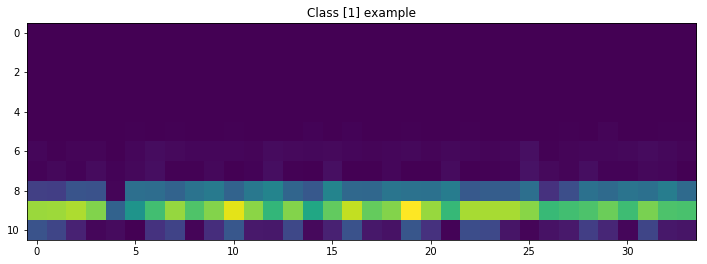

In [3]:
# check a sample point
idx = np.random.choice(X_train.shape[0])
fig = plt.figure(figsize=(12, 10))
ax = plt.axes()
ax.set_title(f'Class {Y_train[idx]} example')
ax.imshow(np.squeeze(X_train[idx, :, :, :]))

## Metrics

In [4]:
# metrics need to be defined according to Keras' standards
# using the backend (tensorflow) tensor operations
def precision(y_true, y_pred):
    """Precision metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (total_positives + K.epsilon())
    return recall


def f1_score(y_true, y_pred):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    """
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1_score = 2 * (p * r) / (p + r + K.epsilon())
    return f1_score

## Convolutional Model

The last Conv + Pool layer is not added since no more pooling operations can be done given the input size

In [5]:
def create_model(input_dim=(11, 34, 1), learning_rate=0.001):
    
    tu_x, tu_y, _ = input_dim
    
    model = Sequential()
    model.add(Conv2D(32, (5, 5), padding='same', input_shape=(tu_x, tu_y, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Conv2D(64, (5, 5), padding='same'))
    #model.add(Activation('relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # default lr for Adam is 0.001 -> change to 0.0001
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=learning_rate), metrics=['accuracy', precision, recall, f1_score])
    
    return model

In [6]:
# redefinition of labels depending on each case
def redefine_labels(Y, target_class):
    """
    Transforms a K-labelled vector into a binary label vector. If Y[i] is equal to target_class
        then Y_binary[i] is 1. Otherwise, Y[i] is 0
    
    Arguments
    Y -- A (m, 1) NumPy array of labels ranging from 0 to (K - 1) with K being the number of classes
    target_class -- Integer indicating the target class
    
    Returns
    Y_binary -- A binary labelled (0 or 1) NumPy array of the same shape as Y
    """
    
    Y_binary = (Y == target_class).astype(int)
    return Y_binary

## ALS
Try new model for ALS classification

In [8]:
Y_train_als = redefine_labels(Y_train, 1)
Y_dev_als = redefine_labels(Y_dev, 1)

In [9]:
# just an initial run to see what happens
input_dim = X_train.shape[1:]
model = create_model(input_dim)

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 34, 32)        832       
_________________________________________________________________
activation (Activation)      (None, 11, 34, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 17, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 17, 64)         51264     
_________________________________________________________________
activation_1 (Activation)    (None, 5, 17, 64)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 8, 64)          102464    
__________

In [11]:
history = model.fit(X_train, Y_train_als, batch_size=128, epochs=300,
              validation_data=(X_dev, Y_dev_als))

Train on 833 samples, validate on 209 samples
Epoch 1/300
833/833 [==============================] - 1s 1ms/step - loss: 0.5337 - acc: 0.7491 - precision: 0.0154 - recall: 0.0615 - f1_score: 0.0246 - val_loss: 0.5126 - val_acc: 0.7895 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/300
833/833 [==============================] - 1s 896us/step - loss: 0.4352 - acc: 0.8271 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.4652 - val_acc: 0.7895 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 3/300
833/833 [==============================] - 1s 1ms/step - loss: 0.3571 - acc: 0.8259 - precision: 0.0000e+00 - recall: 0.0000e+00 - f1_score: 0.0000e+00 - val_loss: 0.3919 - val_acc: 0.7895 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/300
833/833 [==============================] - 1s 1ms/step - loss: 0.3310 - acc: 0.8415 - precision: 0.5511 - rec

833/833 [==============================] - 1s 1ms/step - loss: 0.1755 - acc: 0.9184 - precision: 0.9188 - recall: 0.5618 - f1_score: 0.6862 - val_loss: 0.2777 - val_acc: 0.8900 - val_precision: 0.8554 - val_recall: 0.5676 - val_f1_score: 0.6819
Epoch 33/300
833/833 [==============================] - 1s 926us/step - loss: 0.1582 - acc: 0.9244 - precision: 0.9638 - recall: 0.5858 - f1_score: 0.7269 - val_loss: 0.2754 - val_acc: 0.8852 - val_precision: 0.8261 - val_recall: 0.5676 - val_f1_score: 0.6717
Epoch 34/300
833/833 [==============================] - 1s 1ms/step - loss: 0.1623 - acc: 0.9208 - precision: 0.9250 - recall: 0.6065 - f1_score: 0.7273 - val_loss: 0.3116 - val_acc: 0.8660 - val_precision: 1.0000 - val_recall: 0.3525 - val_f1_score: 0.5183
Epoch 35/300
833/833 [==============================] - 1s 973us/step - loss: 0.1849 - acc: 0.9220 - precision: 0.9426 - recall: 0.5891 - f1_score: 0.7130 - val_loss: 0.3618 - val_acc: 0.8708 - val_precision: 0.8997 - val_recall: 0.4160 

Epoch 64/300
833/833 [==============================] - 1s 769us/step - loss: 0.0927 - acc: 0.9628 - precision: 1.0000 - recall: 0.7770 - f1_score: 0.8718 - val_loss: 0.2470 - val_acc: 0.9234 - val_precision: 0.8261 - val_recall: 0.7930 - val_f1_score: 0.8087
Epoch 65/300
833/833 [==============================] - 1s 1ms/step - loss: 0.0843 - acc: 0.9760 - precision: 0.9626 - recall: 0.8934 - f1_score: 0.9251 - val_loss: 0.2514 - val_acc: 0.9091 - val_precision: 0.9742 - val_recall: 0.5779 - val_f1_score: 0.7214
Epoch 66/300
833/833 [==============================] - 1s 1ms/step - loss: 0.0818 - acc: 0.9640 - precision: 0.9467 - recall: 0.8578 - f1_score: 0.8886 - val_loss: 0.1906 - val_acc: 0.9426 - val_precision: 0.9592 - val_recall: 0.7664 - val_f1_score: 0.8500
Epoch 67/300
833/833 [==============================] - 1s 885us/step - loss: 0.0748 - acc: 0.9688 - precision: 0.9515 - recall: 0.8606 - f1_score: 0.8983 - val_loss: 0.1988 - val_acc: 0.9282 - val_precision: 0.8797 - val_re

Epoch 96/300
833/833 [==============================] - 1s 1000us/step - loss: 0.1120 - acc: 0.9604 - precision: 0.9154 - recall: 0.8915 - f1_score: 0.8857 - val_loss: 0.2490 - val_acc: 0.9139 - val_precision: 0.9742 - val_recall: 0.6045 - val_f1_score: 0.7438
Epoch 97/300
833/833 [==============================] - 1s 1ms/step - loss: 0.0588 - acc: 0.9808 - precision: 0.9451 - recall: 0.9492 - f1_score: 0.9429 - val_loss: 0.4330 - val_acc: 0.8804 - val_precision: 1.0000 - val_recall: 0.4160 - val_f1_score: 0.5825
Epoch 98/300
833/833 [==============================] - 1s 860us/step - loss: 0.0683 - acc: 0.9736 - precision: 0.9465 - recall: 0.9087 - f1_score: 0.9184 - val_loss: 0.2643 - val_acc: 0.9378 - val_precision: 0.9432 - val_recall: 0.7480 - val_f1_score: 0.8342
Epoch 99/300
833/833 [==============================] - 1s 867us/step - loss: 0.0309 - acc: 0.9892 - precision: 1.0000 - recall: 0.9323 - f1_score: 0.9634 - val_loss: 0.2470 - val_acc: 0.9139 - val_precision: 0.8095 - val

833/833 [==============================] - 1s 816us/step - loss: 0.0018 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4001 - val_acc: 0.9282 - val_precision: 0.9058 - val_recall: 0.7398 - val_f1_score: 0.8113
Epoch 128/300
833/833 [==============================] - 1s 815us/step - loss: 0.0014 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.3860 - val_acc: 0.9330 - val_precision: 0.9232 - val_recall: 0.7398 - val_f1_score: 0.8194
Epoch 129/300
833/833 [==============================] - 1s 803us/step - loss: 0.0019 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.3762 - val_acc: 0.9282 - val_precision: 0.9058 - val_recall: 0.7398 - val_f1_score: 0.8113
Epoch 130/300
833/833 [==============================] - 1s 790us/step - loss: 0.0012 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4122 - val_acc: 0.9282 - val_precision: 0.9058 - val_recall: 

833/833 [==============================] - 1s 819us/step - loss: 9.1859e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4420 - val_acc: 0.9330 - val_precision: 0.9078 - val_recall: 0.7664 - val_f1_score: 0.8293
Epoch 159/300
833/833 [==============================] - 1s 810us/step - loss: 5.8289e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4349 - val_acc: 0.9426 - val_precision: 0.9124 - val_recall: 0.8115 - val_f1_score: 0.8571
Epoch 160/300
833/833 [==============================] - 1s 804us/step - loss: 7.7877e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4507 - val_acc: 0.9378 - val_precision: 0.9096 - val_recall: 0.7930 - val_f1_score: 0.8463
Epoch 161/300
833/833 [==============================] - 1s 814us/step - loss: 4.5842e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4508 - val_acc: 0.9426 - val_precision: 0.912

Epoch 189/300
833/833 [==============================] - 1s 866us/step - loss: 3.6320e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4832 - val_acc: 0.9330 - val_precision: 0.9419 - val_recall: 0.7398 - val_f1_score: 0.8239
Epoch 190/300
833/833 [==============================] - 1s 834us/step - loss: 4.2399e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4693 - val_acc: 0.9378 - val_precision: 0.9096 - val_recall: 0.7930 - val_f1_score: 0.8463
Epoch 191/300
833/833 [==============================] - 1s 815us/step - loss: 4.3812e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4539 - val_acc: 0.9378 - val_precision: 0.8834 - val_recall: 0.8115 - val_f1_score: 0.8449
Epoch 192/300
833/833 [==============================] - 1s 864us/step - loss: 4.7259e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4694 - val_acc: 0.9378 - val_pr

Epoch 220/300
833/833 [==============================] - 1s 771us/step - loss: 3.2160e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4787 - val_acc: 0.9426 - val_precision: 0.9124 - val_recall: 0.8115 - val_f1_score: 0.8571
Epoch 221/300
833/833 [==============================] - 1s 720us/step - loss: 2.3043e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4775 - val_acc: 0.9426 - val_precision: 0.9124 - val_recall: 0.8115 - val_f1_score: 0.8571
Epoch 222/300
833/833 [==============================] - 1s 707us/step - loss: 4.2540e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4686 - val_acc: 0.9426 - val_precision: 0.9124 - val_recall: 0.8115 - val_f1_score: 0.8571
Epoch 223/300
833/833 [==============================] - 1s 715us/step - loss: 3.4483e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4641 - val_acc: 0.9426 - val_pr

Epoch 251/300
833/833 [==============================] - 1s 706us/step - loss: 1.4514e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4655 - val_acc: 0.9378 - val_precision: 0.9096 - val_recall: 0.7930 - val_f1_score: 0.8463
Epoch 252/300
833/833 [==============================] - 1s 677us/step - loss: 1.6400e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4770 - val_acc: 0.9378 - val_precision: 0.9096 - val_recall: 0.7930 - val_f1_score: 0.8463
Epoch 253/300
833/833 [==============================] - 1s 813us/step - loss: 2.2496e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4714 - val_acc: 0.9378 - val_precision: 0.9096 - val_recall: 0.7930 - val_f1_score: 0.8463
Epoch 254/300
833/833 [==============================] - 1s 717us/step - loss: 1.1272e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4646 - val_acc: 0.9426 - val_pr

Epoch 282/300
833/833 [==============================] - 1s 775us/step - loss: 1.4689e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.5007 - val_acc: 0.9474 - val_precision: 0.9592 - val_recall: 0.7930 - val_f1_score: 0.8672
Epoch 283/300
833/833 [==============================] - 1s 820us/step - loss: 1.1394e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.5069 - val_acc: 0.9474 - val_precision: 0.9592 - val_recall: 0.7930 - val_f1_score: 0.8672
Epoch 284/300
833/833 [==============================] - 1s 761us/step - loss: 1.0195e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4994 - val_acc: 0.9474 - val_precision: 0.9592 - val_recall: 0.7930 - val_f1_score: 0.8672
Epoch 285/300
833/833 [==============================] - 1s 755us/step - loss: 2.7445e-04 - acc: 1.0000 - precision: 1.0000 - recall: 1.0000 - f1_score: 1.0000 - val_loss: 0.4791 - val_acc: 0.9426 - val_pr

In [12]:
def plot_lines(losses, names):
    
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes()
    ax.set_xlabel('epochs')
    ax.set_ylabel('loss')    
    
    for i, loss in enumerate(losses):
        ax.plot(loss, label=names[i])

    ax.legend()
    plt.grid()
    plt.show()
    
    return None

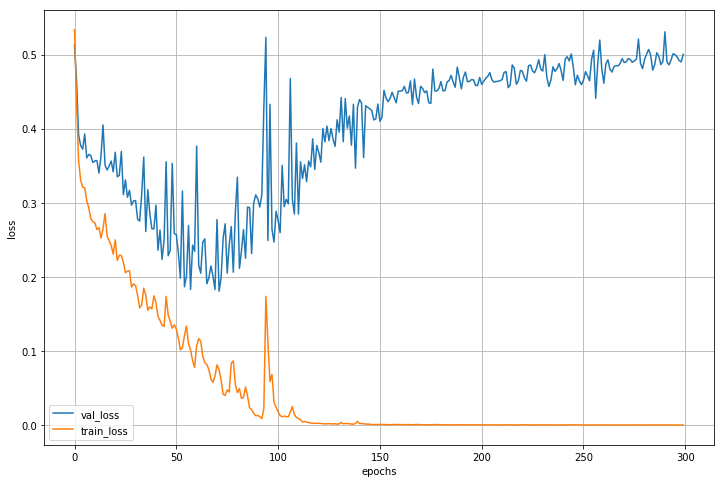

In [13]:
plot_lines([history.history['val_loss'], history.history['loss']], ['val_loss', 'train_loss'])

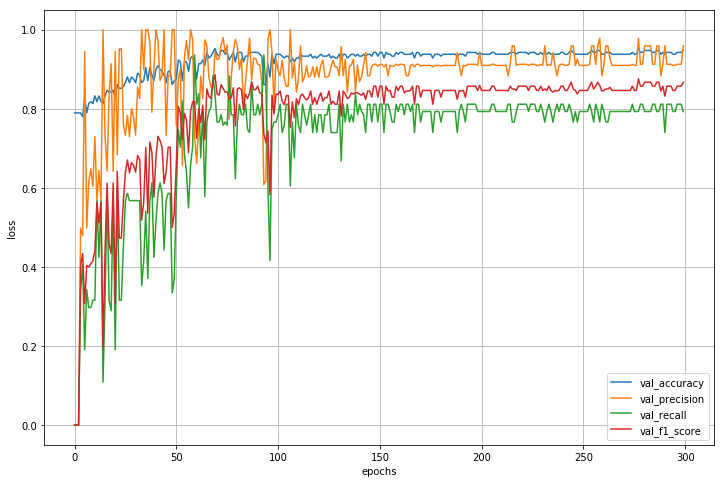

In [19]:
plot_lines([history.history['val_acc'], history.history['val_precision'], history.history['val_recall'], history.history['val_f1_score']],
            ['val_accuracy', 'val_precision', 'val_recall', 'val_f1_score'])

In [25]:
# let's not forget the class imbalance
zero_accuracy = (np.sum(Y_dev_als == 0)) / Y_dev_als.shape[0]
print(f'If all examples were predicted to be of the negative class,\
the accuracy would be {zero_accuracy}')

If all examples were predicted to be of the negative class,the accuracy would be 0.7894736842105263


The model may be too big for the data. The model is overfitting the training set.

In [15]:
rootdir = os.pardir
out_dir = os.path.join(rootdir, 'trained_models')

name = 'ALS_BIG_1'

model_json = model.to_json()
model_path = os.path.join(out_dir, name + '_arch.json')
with open(model_path, 'w') as json_file:
    json_file.write(model_json)

# save model weigths (saving entire model is problematic)
weights_path = os.path.join(out_dir, name + '_weights.h5')
model.save_weights(weights_path)